# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

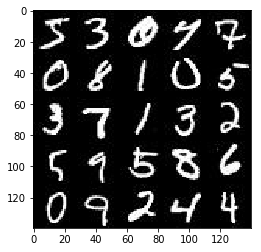

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

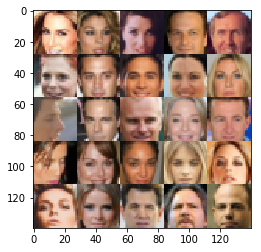

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False, alpha = .2, keep_prob=.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 14*14*64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7*7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True, alpha = .2, keep_prob=.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*alpha, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2*alpha, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3*alpha, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logit_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logit_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                _ = sess.run([d_opt, g_opt], feed_dict={input_real: batch_images, input_z: batch_z, 
                                                        learn_rate: learning_rate})
                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.1078... Generator Loss: 17.8691
Epoch 0/2... Discriminator Loss: 0.5907... Generator Loss: 1.6257
Epoch 0/2... Discriminator Loss: 0.3274... Generator Loss: 2.9016
Epoch 0/2... Discriminator Loss: 0.4529... Generator Loss: 2.5498


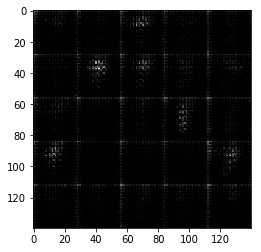

Epoch 0/2... Discriminator Loss: 0.4476... Generator Loss: 2.4106
Epoch 0/2... Discriminator Loss: 0.6797... Generator Loss: 2.9816
Epoch 0/2... Discriminator Loss: 2.1188... Generator Loss: 0.7731
Epoch 0/2... Discriminator Loss: 0.6743... Generator Loss: 2.1417
Epoch 0/2... Discriminator Loss: 0.7139... Generator Loss: 1.8312


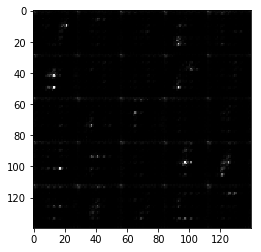

Epoch 0/2... Discriminator Loss: 1.3086... Generator Loss: 0.9979
Epoch 0/2... Discriminator Loss: 1.1101... Generator Loss: 0.6336
Epoch 0/2... Discriminator Loss: 0.9875... Generator Loss: 4.4581
Epoch 0/2... Discriminator Loss: 1.4653... Generator Loss: 0.5398
Epoch 0/2... Discriminator Loss: 1.9789... Generator Loss: 0.3767


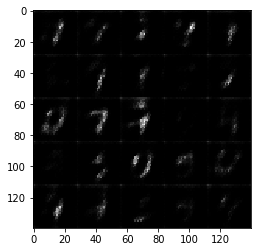

Epoch 0/2... Discriminator Loss: 1.9809... Generator Loss: 0.7436
Epoch 0/2... Discriminator Loss: 1.0677... Generator Loss: 0.7436
Epoch 0/2... Discriminator Loss: 1.7047... Generator Loss: 0.7157
Epoch 0/2... Discriminator Loss: 0.9500... Generator Loss: 1.5784
Epoch 0/2... Discriminator Loss: 0.7134... Generator Loss: 1.7016


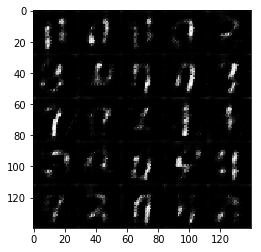

Epoch 0/2... Discriminator Loss: 1.1309... Generator Loss: 0.8296
Epoch 0/2... Discriminator Loss: 1.8423... Generator Loss: 0.4769
Epoch 0/2... Discriminator Loss: 1.0816... Generator Loss: 2.7682
Epoch 0/2... Discriminator Loss: 0.9210... Generator Loss: 1.0429
Epoch 0/2... Discriminator Loss: 1.3235... Generator Loss: 1.0908


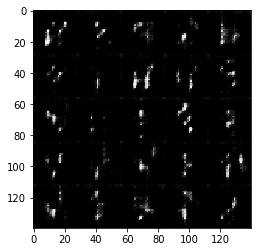

Epoch 0/2... Discriminator Loss: 1.3016... Generator Loss: 0.7276
Epoch 0/2... Discriminator Loss: 0.7624... Generator Loss: 1.5331
Epoch 0/2... Discriminator Loss: 0.8302... Generator Loss: 1.7996
Epoch 0/2... Discriminator Loss: 0.9217... Generator Loss: 1.0116
Epoch 0/2... Discriminator Loss: 1.1785... Generator Loss: 3.2247


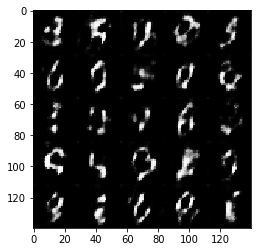

Epoch 0/2... Discriminator Loss: 1.1771... Generator Loss: 1.1644
Epoch 0/2... Discriminator Loss: 0.6302... Generator Loss: 1.7322
Epoch 0/2... Discriminator Loss: 1.7035... Generator Loss: 0.3442
Epoch 0/2... Discriminator Loss: 1.0991... Generator Loss: 0.6974
Epoch 0/2... Discriminator Loss: 0.7260... Generator Loss: 1.5020


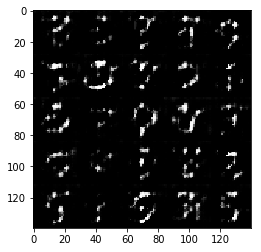

Epoch 0/2... Discriminator Loss: 0.6985... Generator Loss: 1.8940
Epoch 0/2... Discriminator Loss: 1.5387... Generator Loss: 2.9447
Epoch 0/2... Discriminator Loss: 0.8511... Generator Loss: 1.6034
Epoch 0/2... Discriminator Loss: 1.1269... Generator Loss: 2.9677
Epoch 0/2... Discriminator Loss: 0.6669... Generator Loss: 1.7893


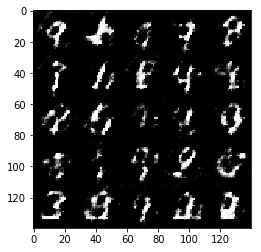

Epoch 0/2... Discriminator Loss: 0.9592... Generator Loss: 1.2572
Epoch 0/2... Discriminator Loss: 4.2809... Generator Loss: 0.0523
Epoch 0/2... Discriminator Loss: 0.8559... Generator Loss: 1.5443
Epoch 0/2... Discriminator Loss: 0.7681... Generator Loss: 1.5725
Epoch 0/2... Discriminator Loss: 2.4258... Generator Loss: 0.2342


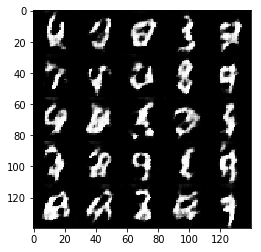

Epoch 0/2... Discriminator Loss: 0.5971... Generator Loss: 1.8071
Epoch 0/2... Discriminator Loss: 0.8267... Generator Loss: 1.1621
Epoch 0/2... Discriminator Loss: 1.6316... Generator Loss: 0.4574
Epoch 0/2... Discriminator Loss: 1.4539... Generator Loss: 3.9494
Epoch 0/2... Discriminator Loss: 1.4321... Generator Loss: 0.6792


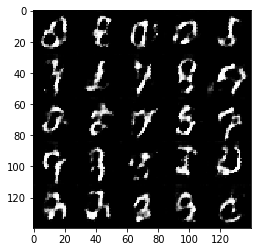

Epoch 0/2... Discriminator Loss: 1.0594... Generator Loss: 1.6744
Epoch 0/2... Discriminator Loss: 0.9003... Generator Loss: 1.0289
Epoch 0/2... Discriminator Loss: 0.5445... Generator Loss: 2.0585
Epoch 0/2... Discriminator Loss: 0.7846... Generator Loss: 1.6418
Epoch 0/2... Discriminator Loss: 1.2087... Generator Loss: 0.8237


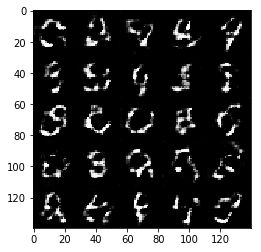

Epoch 0/2... Discriminator Loss: 2.3330... Generator Loss: 0.2833
Epoch 0/2... Discriminator Loss: 1.4347... Generator Loss: 1.6028
Epoch 0/2... Discriminator Loss: 1.3536... Generator Loss: 0.6090
Epoch 0/2... Discriminator Loss: 1.1508... Generator Loss: 0.9629
Epoch 0/2... Discriminator Loss: 0.7395... Generator Loss: 1.2811


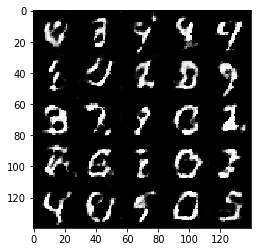

Epoch 0/2... Discriminator Loss: 1.3950... Generator Loss: 0.5700
Epoch 0/2... Discriminator Loss: 0.9929... Generator Loss: 0.8613
Epoch 0/2... Discriminator Loss: 1.5196... Generator Loss: 0.4410
Epoch 0/2... Discriminator Loss: 0.9970... Generator Loss: 1.0780
Epoch 0/2... Discriminator Loss: 1.1050... Generator Loss: 1.6618


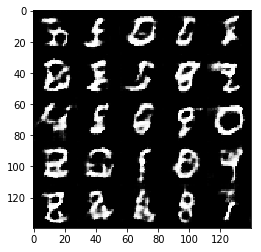

Epoch 0/2... Discriminator Loss: 1.0585... Generator Loss: 1.0198
Epoch 0/2... Discriminator Loss: 1.1189... Generator Loss: 2.2065
Epoch 0/2... Discriminator Loss: 0.8820... Generator Loss: 1.7681
Epoch 0/2... Discriminator Loss: 0.7814... Generator Loss: 1.8047
Epoch 0/2... Discriminator Loss: 1.1932... Generator Loss: 0.8411


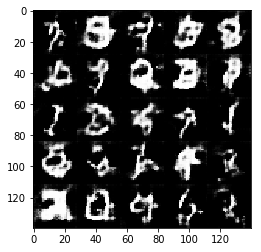

Epoch 0/2... Discriminator Loss: 0.6699... Generator Loss: 1.5150
Epoch 0/2... Discriminator Loss: 2.2375... Generator Loss: 0.2425
Epoch 0/2... Discriminator Loss: 1.0013... Generator Loss: 0.8621
Epoch 0/2... Discriminator Loss: 0.9446... Generator Loss: 1.1329
Epoch 0/2... Discriminator Loss: 1.0986... Generator Loss: 0.8200


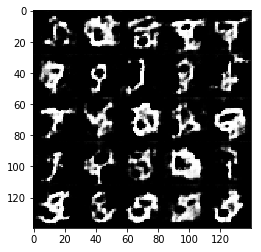

Epoch 0/2... Discriminator Loss: 0.5614... Generator Loss: 1.3964
Epoch 0/2... Discriminator Loss: 0.9384... Generator Loss: 1.6410
Epoch 0/2... Discriminator Loss: 0.8695... Generator Loss: 0.9926
Epoch 0/2... Discriminator Loss: 1.0194... Generator Loss: 1.1580
Epoch 0/2... Discriminator Loss: 1.0398... Generator Loss: 0.9117


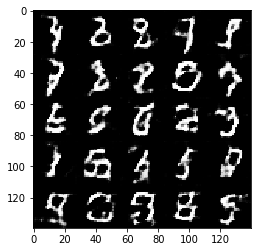

Epoch 0/2... Discriminator Loss: 1.9232... Generator Loss: 0.3218
Epoch 0/2... Discriminator Loss: 0.7769... Generator Loss: 1.3810
Epoch 0/2... Discriminator Loss: 1.1248... Generator Loss: 0.9319
Epoch 0/2... Discriminator Loss: 1.3121... Generator Loss: 0.7969
Epoch 0/2... Discriminator Loss: 0.7427... Generator Loss: 1.2498


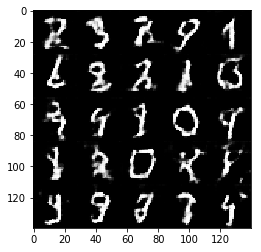

Epoch 0/2... Discriminator Loss: 1.2800... Generator Loss: 0.8492
Epoch 0/2... Discriminator Loss: 1.1121... Generator Loss: 0.8247
Epoch 0/2... Discriminator Loss: 0.9226... Generator Loss: 1.3801
Epoch 0/2... Discriminator Loss: 1.7247... Generator Loss: 0.3603
Epoch 0/2... Discriminator Loss: 1.3719... Generator Loss: 0.4851


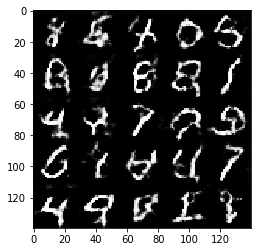

Epoch 0/2... Discriminator Loss: 1.1004... Generator Loss: 0.8612
Epoch 0/2... Discriminator Loss: 0.6514... Generator Loss: 1.4553
Epoch 0/2... Discriminator Loss: 0.9807... Generator Loss: 0.7639
Epoch 0/2... Discriminator Loss: 2.1906... Generator Loss: 0.2104
Epoch 0/2... Discriminator Loss: 1.6468... Generator Loss: 0.4465


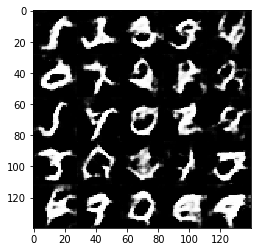

Epoch 0/2... Discriminator Loss: 1.1791... Generator Loss: 0.6226
Epoch 0/2... Discriminator Loss: 0.7983... Generator Loss: 2.5754
Epoch 0/2... Discriminator Loss: 1.0051... Generator Loss: 0.9558
Epoch 0/2... Discriminator Loss: 0.8017... Generator Loss: 1.4286
Epoch 0/2... Discriminator Loss: 1.1008... Generator Loss: 0.8182


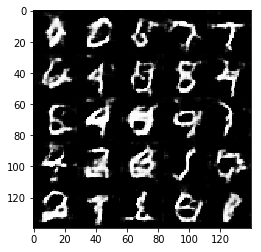

Epoch 0/2... Discriminator Loss: 1.7115... Generator Loss: 0.3860
Epoch 0/2... Discriminator Loss: 0.9087... Generator Loss: 1.0998
Epoch 0/2... Discriminator Loss: 0.6382... Generator Loss: 1.3849
Epoch 0/2... Discriminator Loss: 1.0793... Generator Loss: 1.5299
Epoch 0/2... Discriminator Loss: 1.4502... Generator Loss: 0.3770


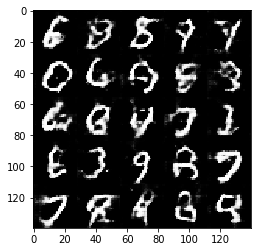

Epoch 0/2... Discriminator Loss: 0.6749... Generator Loss: 1.3061
Epoch 0/2... Discriminator Loss: 1.4880... Generator Loss: 0.3931
Epoch 0/2... Discriminator Loss: 0.7589... Generator Loss: 0.9702
Epoch 0/2... Discriminator Loss: 0.8181... Generator Loss: 2.0123
Epoch 0/2... Discriminator Loss: 1.6210... Generator Loss: 0.3503


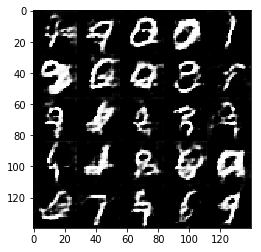

Epoch 0/2... Discriminator Loss: 1.3644... Generator Loss: 0.4939
Epoch 0/2... Discriminator Loss: 0.5154... Generator Loss: 1.6444
Epoch 0/2... Discriminator Loss: 1.3624... Generator Loss: 0.7262
Epoch 0/2... Discriminator Loss: 1.0249... Generator Loss: 1.0073
Epoch 0/2... Discriminator Loss: 1.3789... Generator Loss: 0.7284


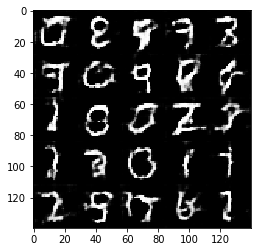

Epoch 0/2... Discriminator Loss: 1.0683... Generator Loss: 0.6508
Epoch 0/2... Discriminator Loss: 1.3434... Generator Loss: 0.5164
Epoch 0/2... Discriminator Loss: 1.5179... Generator Loss: 0.3909
Epoch 0/2... Discriminator Loss: 0.8405... Generator Loss: 0.8297
Epoch 0/2... Discriminator Loss: 0.8522... Generator Loss: 2.3926


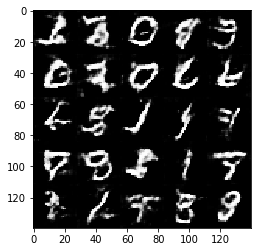

Epoch 0/2... Discriminator Loss: 0.5660... Generator Loss: 2.0792
Epoch 0/2... Discriminator Loss: 0.7015... Generator Loss: 1.3852
Epoch 0/2... Discriminator Loss: 0.6847... Generator Loss: 2.8452
Epoch 0/2... Discriminator Loss: 1.5383... Generator Loss: 0.4832
Epoch 0/2... Discriminator Loss: 0.8665... Generator Loss: 1.3443


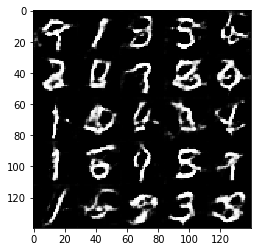

Epoch 0/2... Discriminator Loss: 1.1171... Generator Loss: 0.8923
Epoch 0/2... Discriminator Loss: 0.7293... Generator Loss: 1.3612
Epoch 0/2... Discriminator Loss: 1.0921... Generator Loss: 1.1185
Epoch 0/2... Discriminator Loss: 0.7000... Generator Loss: 1.4085
Epoch 0/2... Discriminator Loss: 1.0814... Generator Loss: 1.3277


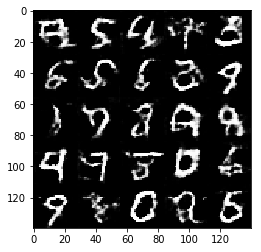

Epoch 0/2... Discriminator Loss: 0.7000... Generator Loss: 1.3938
Epoch 0/2... Discriminator Loss: 1.0512... Generator Loss: 0.8804
Epoch 0/2... Discriminator Loss: 1.0050... Generator Loss: 1.0066
Epoch 0/2... Discriminator Loss: 1.2882... Generator Loss: 0.9646
Epoch 0/2... Discriminator Loss: 0.9637... Generator Loss: 1.3315


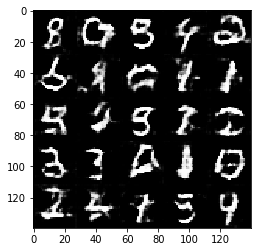

Epoch 0/2... Discriminator Loss: 0.7600... Generator Loss: 1.6095
Epoch 0/2... Discriminator Loss: 1.4326... Generator Loss: 0.5938
Epoch 0/2... Discriminator Loss: 0.9427... Generator Loss: 0.6368
Epoch 0/2... Discriminator Loss: 0.9118... Generator Loss: 0.9152
Epoch 0/2... Discriminator Loss: 0.9410... Generator Loss: 0.9178


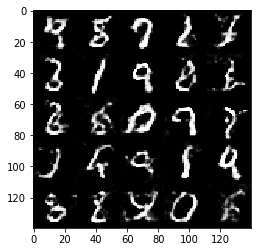

Epoch 0/2... Discriminator Loss: 1.2870... Generator Loss: 0.4912
Epoch 0/2... Discriminator Loss: 0.8146... Generator Loss: 1.2412
Epoch 0/2... Discriminator Loss: 0.8579... Generator Loss: 1.1961
Epoch 0/2... Discriminator Loss: 1.7228... Generator Loss: 2.7978
Epoch 0/2... Discriminator Loss: 1.0534... Generator Loss: 0.8577


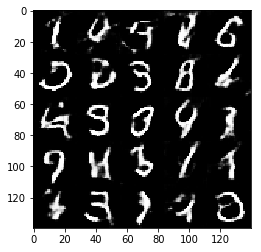

Epoch 0/2... Discriminator Loss: 0.6757... Generator Loss: 1.2056
Epoch 0/2... Discriminator Loss: 0.9980... Generator Loss: 0.9256
Epoch 0/2... Discriminator Loss: 0.6918... Generator Loss: 1.3037
Epoch 0/2... Discriminator Loss: 0.9336... Generator Loss: 0.7792
Epoch 0/2... Discriminator Loss: 1.2568... Generator Loss: 0.8990


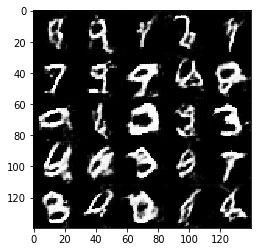

Epoch 0/2... Discriminator Loss: 0.8075... Generator Loss: 1.7662
Epoch 0/2... Discriminator Loss: 1.2976... Generator Loss: 0.6074
Epoch 0/2... Discriminator Loss: 0.7683... Generator Loss: 1.1780
Epoch 0/2... Discriminator Loss: 0.9140... Generator Loss: 0.8565
Epoch 0/2... Discriminator Loss: 0.6071... Generator Loss: 1.8441


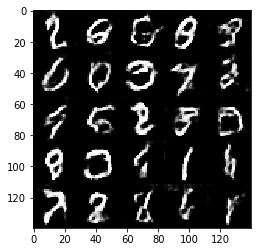

Epoch 0/2... Discriminator Loss: 0.9939... Generator Loss: 0.9770
Epoch 0/2... Discriminator Loss: 0.8760... Generator Loss: 1.6393
Epoch 0/2... Discriminator Loss: 1.1416... Generator Loss: 2.3997
Epoch 0/2... Discriminator Loss: 1.1735... Generator Loss: 1.2358
Epoch 0/2... Discriminator Loss: 0.5340... Generator Loss: 1.8530


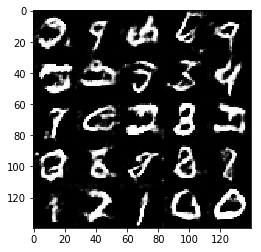

Epoch 0/2... Discriminator Loss: 1.5103... Generator Loss: 0.4438
Epoch 0/2... Discriminator Loss: 0.9246... Generator Loss: 1.4068
Epoch 0/2... Discriminator Loss: 1.0296... Generator Loss: 1.0530
Epoch 0/2... Discriminator Loss: 1.1855... Generator Loss: 0.7265
Epoch 0/2... Discriminator Loss: 1.1762... Generator Loss: 1.0694


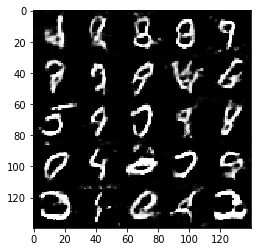

Epoch 0/2... Discriminator Loss: 0.7940... Generator Loss: 1.4606
Epoch 0/2... Discriminator Loss: 0.8531... Generator Loss: 0.9884
Epoch 0/2... Discriminator Loss: 1.1468... Generator Loss: 0.6658
Epoch 0/2... Discriminator Loss: 0.7062... Generator Loss: 1.7830
Epoch 0/2... Discriminator Loss: 1.1523... Generator Loss: 0.7773


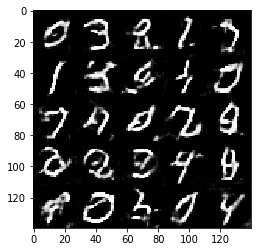

Epoch 0/2... Discriminator Loss: 1.1326... Generator Loss: 0.6457
Epoch 0/2... Discriminator Loss: 1.3808... Generator Loss: 0.7995
Epoch 0/2... Discriminator Loss: 2.2801... Generator Loss: 2.9568
Epoch 0/2... Discriminator Loss: 2.4726... Generator Loss: 0.2103
Epoch 0/2... Discriminator Loss: 0.7775... Generator Loss: 1.8026


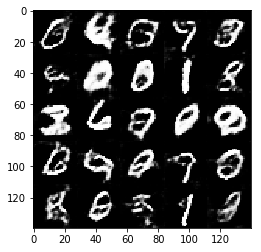

Epoch 0/2... Discriminator Loss: 0.9260... Generator Loss: 2.4488
Epoch 0/2... Discriminator Loss: 0.6932... Generator Loss: 1.3666
Epoch 0/2... Discriminator Loss: 0.6709... Generator Loss: 1.8849
Epoch 0/2... Discriminator Loss: 1.8256... Generator Loss: 0.3120
Epoch 0/2... Discriminator Loss: 0.5230... Generator Loss: 1.5139


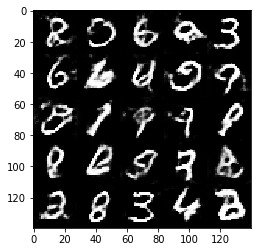

Epoch 0/2... Discriminator Loss: 0.5961... Generator Loss: 1.7509
Epoch 0/2... Discriminator Loss: 0.8669... Generator Loss: 1.2969
Epoch 0/2... Discriminator Loss: 0.6602... Generator Loss: 1.4265
Epoch 0/2... Discriminator Loss: 0.9843... Generator Loss: 0.9042
Epoch 0/2... Discriminator Loss: 0.7560... Generator Loss: 3.1398


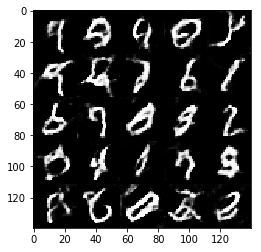

Epoch 0/2... Discriminator Loss: 1.1679... Generator Loss: 0.9226
Epoch 0/2... Discriminator Loss: 1.4784... Generator Loss: 0.4546
Epoch 0/2... Discriminator Loss: 0.6985... Generator Loss: 1.7720
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 1.1222
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 0.8907


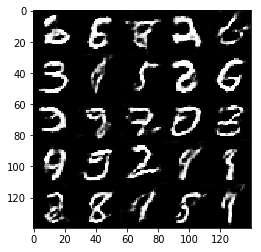

Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 1.6465
Epoch 1/2... Discriminator Loss: 0.6860... Generator Loss: 1.5855
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 1.5500... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 0.9103


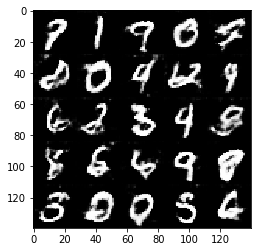

Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.5290
Epoch 1/2... Discriminator Loss: 1.6274... Generator Loss: 0.4577
Epoch 1/2... Discriminator Loss: 0.4130... Generator Loss: 1.4717
Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 1.1039


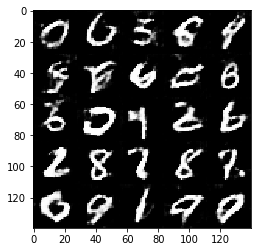

Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 2.2851
Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.0655
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.6792
Epoch 1/2... Discriminator Loss: 0.7571... Generator Loss: 1.0758


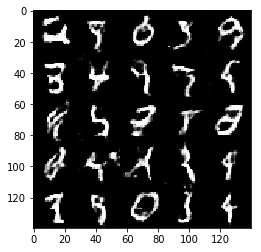

Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 1.1989
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 2.4253
Epoch 1/2... Discriminator Loss: 1.7265... Generator Loss: 0.5041
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 0.5688


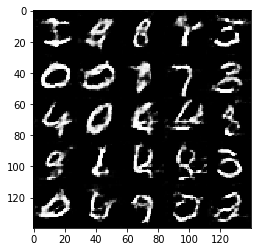

Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 2.1762
Epoch 1/2... Discriminator Loss: 1.8937... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 3.2059
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 1.1721
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 0.9224


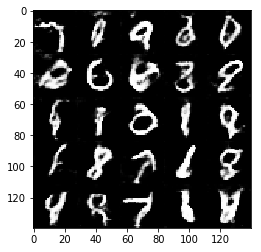

Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 1.1781
Epoch 1/2... Discriminator Loss: 0.7425... Generator Loss: 1.1825
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 0.4428... Generator Loss: 2.0329


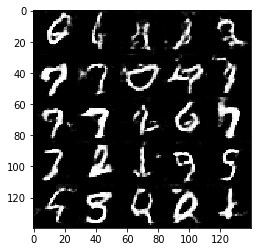

Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 0.5278... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.2933
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 2.3528
Epoch 1/2... Discriminator Loss: 0.3586... Generator Loss: 2.0683


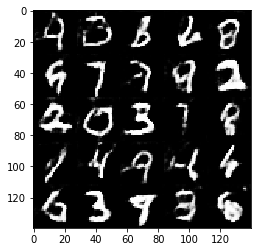

Epoch 1/2... Discriminator Loss: 0.6790... Generator Loss: 1.2499
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 1.2397
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.1765
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.6107
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.3097


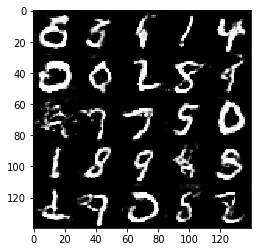

Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 1.8407
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 1.8693
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.4200


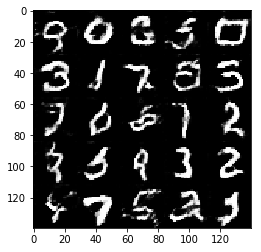

Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 0.4830... Generator Loss: 1.8458
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.7029


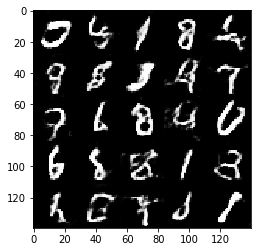

Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.7339
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.5960
Epoch 1/2... Discriminator Loss: 0.4635... Generator Loss: 1.9033
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 1.7486
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.6270


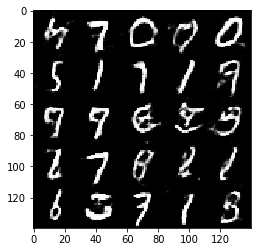

Epoch 1/2... Discriminator Loss: 0.8411... Generator Loss: 1.0478
Epoch 1/2... Discriminator Loss: 0.5786... Generator Loss: 2.0817
Epoch 1/2... Discriminator Loss: 0.7396... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.3797
Epoch 1/2... Discriminator Loss: 0.5727... Generator Loss: 1.3194


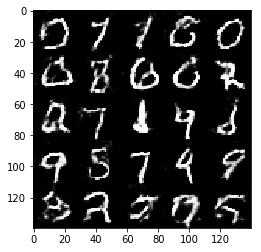

Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 0.8781
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 0.9943
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.9545
Epoch 1/2... Discriminator Loss: 0.4913... Generator Loss: 1.7912


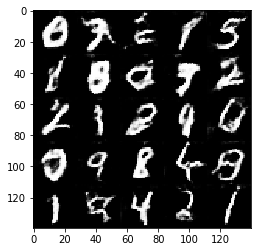

Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 0.4786... Generator Loss: 3.2392
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.4399
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.3609


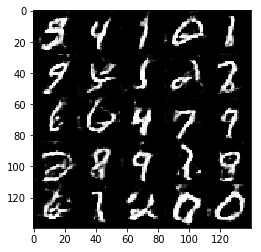

Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.7947... Generator Loss: 0.3949
Epoch 1/2... Discriminator Loss: 0.2886... Generator Loss: 2.0609
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 1.9319
Epoch 1/2... Discriminator Loss: 1.6504... Generator Loss: 0.4410


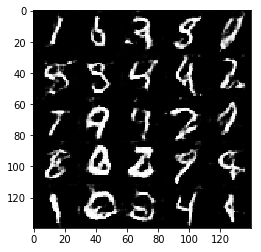

Epoch 1/2... Discriminator Loss: 0.8442... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 2.7344
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 1.2857
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 1.4210
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 1.7435


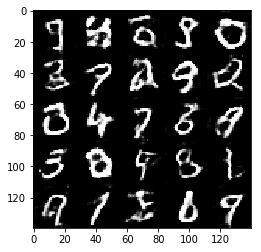

Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 1.1768
Epoch 1/2... Discriminator Loss: 0.3910... Generator Loss: 2.7603
Epoch 1/2... Discriminator Loss: 0.5257... Generator Loss: 1.9075
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 0.6647... Generator Loss: 1.7253


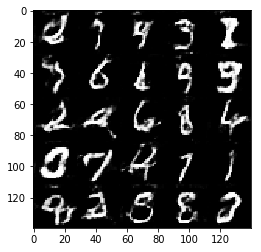

Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 2.1179
Epoch 1/2... Discriminator Loss: 0.3037... Generator Loss: 2.2939
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.0416
Epoch 1/2... Discriminator Loss: 0.3990... Generator Loss: 3.1833
Epoch 1/2... Discriminator Loss: 0.6174... Generator Loss: 2.9137


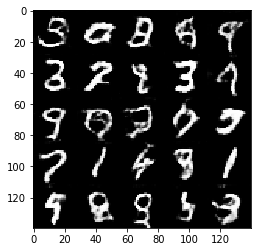

Epoch 1/2... Discriminator Loss: 0.9427... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.5446
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 2.1519
Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 1.1054
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 1.3273


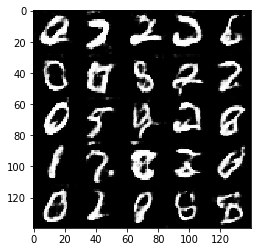

Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 3.9288
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 0.5150... Generator Loss: 2.1540
Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 1.7383


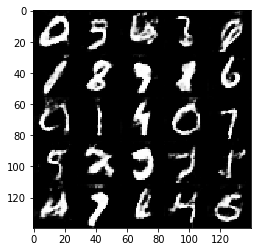

Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 1.3363
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 2.7838
Epoch 1/2... Discriminator Loss: 0.4497... Generator Loss: 2.5373
Epoch 1/2... Discriminator Loss: 0.2744... Generator Loss: 2.2745
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.0344


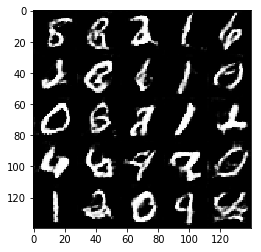

Epoch 1/2... Discriminator Loss: 0.3215... Generator Loss: 2.9872
Epoch 1/2... Discriminator Loss: 0.6898... Generator Loss: 1.3493
Epoch 1/2... Discriminator Loss: 0.6430... Generator Loss: 1.5631
Epoch 1/2... Discriminator Loss: 0.4745... Generator Loss: 3.1728
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.4559


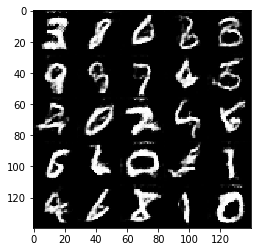

Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 3.3595
Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 3.6540
Epoch 1/2... Discriminator Loss: 0.3985... Generator Loss: 2.2633
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 0.7419


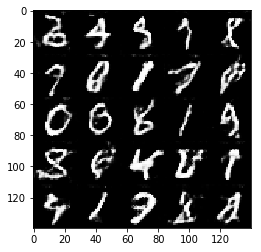

Epoch 1/2... Discriminator Loss: 0.5557... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 0.3795... Generator Loss: 2.8000
Epoch 1/2... Discriminator Loss: 0.5365... Generator Loss: 2.8245
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 1.0508


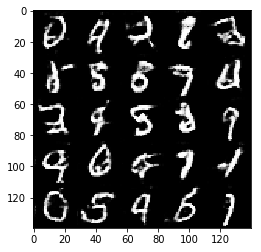

Epoch 1/2... Discriminator Loss: 0.6678... Generator Loss: 1.6619
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 2.8740
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 2.0035
Epoch 1/2... Discriminator Loss: 0.3811... Generator Loss: 2.7630
Epoch 1/2... Discriminator Loss: 1.5336... Generator Loss: 0.5478


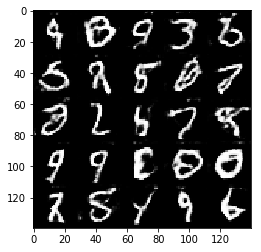

Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 1.0337
Epoch 1/2... Discriminator Loss: 0.4575... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 4.0982
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 2.2928
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.7429


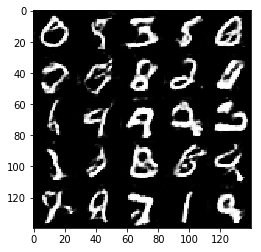

Epoch 1/2... Discriminator Loss: 0.3613... Generator Loss: 1.7374
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.6641
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 0.9815
Epoch 1/2... Discriminator Loss: 1.6668... Generator Loss: 5.3943
Epoch 1/2... Discriminator Loss: 1.7201... Generator Loss: 0.3023


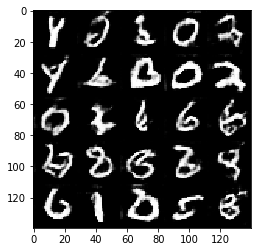

Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.3557
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 2.9403
Epoch 1/2... Discriminator Loss: 0.4644... Generator Loss: 1.7068


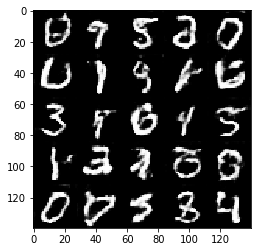

Epoch 1/2... Discriminator Loss: 0.2819... Generator Loss: 2.2472
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 0.2109... Generator Loss: 1.8767
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.3590
Epoch 1/2... Discriminator Loss: 0.1241... Generator Loss: 3.3116


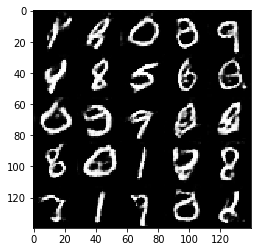

Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 4.5131
Epoch 1/2... Discriminator Loss: 0.6777... Generator Loss: 1.0170
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 0.5352... Generator Loss: 1.5244
Epoch 1/2... Discriminator Loss: 0.4139... Generator Loss: 2.4677


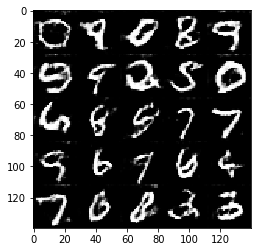

Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.5471... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 0.7680... Generator Loss: 3.6642
Epoch 1/2... Discriminator Loss: 0.5276... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 1.6809


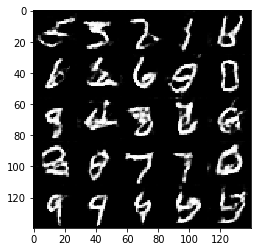

Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.4054
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 3.2587
Epoch 1/2... Discriminator Loss: 0.3388... Generator Loss: 3.2265
Epoch 1/2... Discriminator Loss: 0.3410... Generator Loss: 2.7302


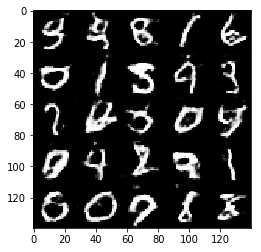

Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 2.0690
Epoch 1/2... Discriminator Loss: 0.5763... Generator Loss: 1.3055
Epoch 1/2... Discriminator Loss: 0.3619... Generator Loss: 3.1780
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 3.2843
Epoch 1/2... Discriminator Loss: 0.4987... Generator Loss: 1.3481


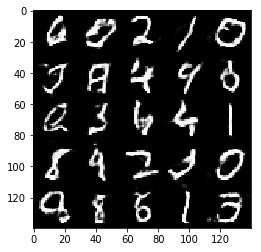

Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 0.3014... Generator Loss: 2.3615
Epoch 1/2... Discriminator Loss: 0.6285... Generator Loss: 1.9085
Epoch 1/2... Discriminator Loss: 0.7130... Generator Loss: 1.0560
Epoch 1/2... Discriminator Loss: 2.9742... Generator Loss: 0.0809


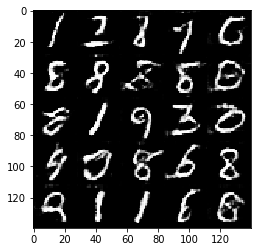

Epoch 1/2... Discriminator Loss: 3.7683... Generator Loss: 0.0738
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 1.6549
Epoch 1/2... Discriminator Loss: 0.6652... Generator Loss: 3.7454
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.5087


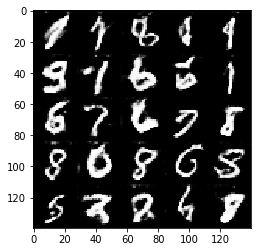

Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 3.5729
Epoch 1/2... Discriminator Loss: 0.6994... Generator Loss: 1.5803
Epoch 1/2... Discriminator Loss: 0.5450... Generator Loss: 1.8966
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 1.8791
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.5038


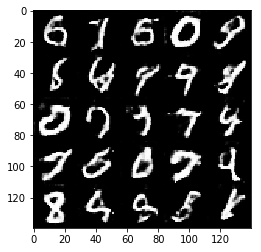

Epoch 1/2... Discriminator Loss: 0.4741... Generator Loss: 2.0299
Epoch 1/2... Discriminator Loss: 0.3095... Generator Loss: 2.5575
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 2.8590
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 2.3283
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 1.0156


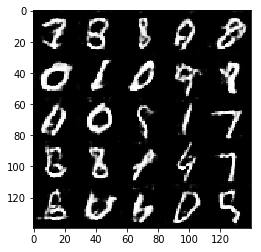

Epoch 1/2... Discriminator Loss: 0.2239... Generator Loss: 2.6478


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.5190... Generator Loss: 9.7559
Epoch 0/1... Discriminator Loss: 0.6651... Generator Loss: 2.0253
Epoch 0/1... Discriminator Loss: 0.1439... Generator Loss: 22.9134
Epoch 0/1... Discriminator Loss: 0.1933... Generator Loss: 14.1999


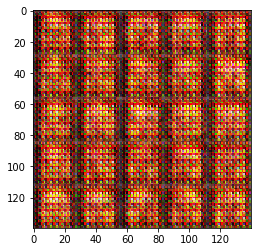

Epoch 0/1... Discriminator Loss: 1.6561... Generator Loss: 0.5291
Epoch 0/1... Discriminator Loss: 0.2613... Generator Loss: 2.8796
Epoch 0/1... Discriminator Loss: 0.5561... Generator Loss: 2.3375
Epoch 0/1... Discriminator Loss: 0.5864... Generator Loss: 1.6594
Epoch 0/1... Discriminator Loss: 1.0775... Generator Loss: 0.7599


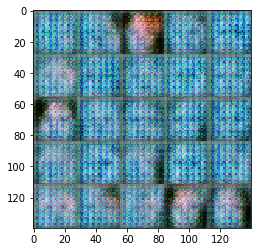

Epoch 0/1... Discriminator Loss: 0.4763... Generator Loss: 1.8716
Epoch 0/1... Discriminator Loss: 1.0384... Generator Loss: 0.8801
Epoch 0/1... Discriminator Loss: 0.8602... Generator Loss: 0.9318
Epoch 0/1... Discriminator Loss: 0.4105... Generator Loss: 4.0045
Epoch 0/1... Discriminator Loss: 1.5652... Generator Loss: 0.4078


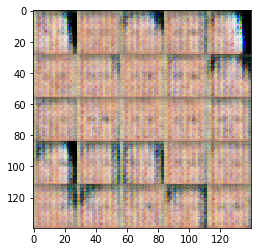

Epoch 0/1... Discriminator Loss: 0.7007... Generator Loss: 1.2663
Epoch 0/1... Discriminator Loss: 0.6607... Generator Loss: 2.4962
Epoch 0/1... Discriminator Loss: 0.4134... Generator Loss: 2.1227
Epoch 0/1... Discriminator Loss: 1.7591... Generator Loss: 0.3423
Epoch 0/1... Discriminator Loss: 0.8849... Generator Loss: 1.2438


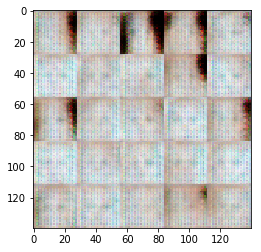

Epoch 0/1... Discriminator Loss: 0.7236... Generator Loss: 1.3581
Epoch 0/1... Discriminator Loss: 2.1256... Generator Loss: 0.2392
Epoch 0/1... Discriminator Loss: 0.6294... Generator Loss: 2.0908
Epoch 0/1... Discriminator Loss: 1.1544... Generator Loss: 0.8864
Epoch 0/1... Discriminator Loss: 0.6423... Generator Loss: 1.8299


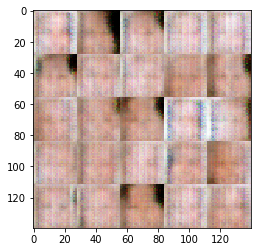

Epoch 0/1... Discriminator Loss: 0.6894... Generator Loss: 1.2536
Epoch 0/1... Discriminator Loss: 0.9054... Generator Loss: 2.0506
Epoch 0/1... Discriminator Loss: 0.9363... Generator Loss: 1.3879
Epoch 0/1... Discriminator Loss: 0.9160... Generator Loss: 1.2276
Epoch 0/1... Discriminator Loss: 1.1110... Generator Loss: 3.2247


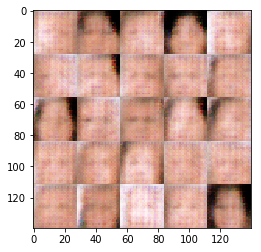

Epoch 0/1... Discriminator Loss: 0.6776... Generator Loss: 1.6288
Epoch 0/1... Discriminator Loss: 0.4597... Generator Loss: 2.5498
Epoch 0/1... Discriminator Loss: 0.2062... Generator Loss: 2.7371
Epoch 0/1... Discriminator Loss: 1.2373... Generator Loss: 1.1803
Epoch 0/1... Discriminator Loss: 1.5038... Generator Loss: 4.5933


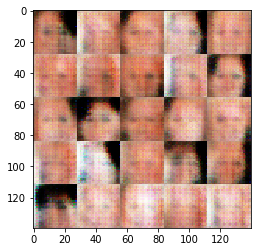

Epoch 0/1... Discriminator Loss: 0.8623... Generator Loss: 1.0534
Epoch 0/1... Discriminator Loss: 1.8508... Generator Loss: 0.3127
Epoch 0/1... Discriminator Loss: 0.7522... Generator Loss: 2.3359
Epoch 0/1... Discriminator Loss: 0.6577... Generator Loss: 1.3255
Epoch 0/1... Discriminator Loss: 2.0344... Generator Loss: 0.2443


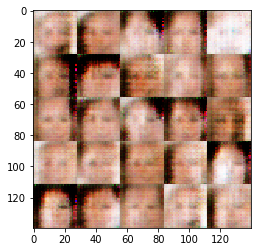

Epoch 0/1... Discriminator Loss: 2.3297... Generator Loss: 0.1863
Epoch 0/1... Discriminator Loss: 0.8479... Generator Loss: 1.4928
Epoch 0/1... Discriminator Loss: 0.6515... Generator Loss: 2.4693
Epoch 0/1... Discriminator Loss: 0.7246... Generator Loss: 1.7727
Epoch 0/1... Discriminator Loss: 0.6665... Generator Loss: 1.5501


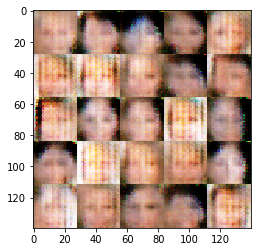

Epoch 0/1... Discriminator Loss: 3.1907... Generator Loss: 5.1599
Epoch 0/1... Discriminator Loss: 0.7177... Generator Loss: 1.1342
Epoch 0/1... Discriminator Loss: 1.6332... Generator Loss: 0.4088
Epoch 0/1... Discriminator Loss: 0.6686... Generator Loss: 1.5040
Epoch 0/1... Discriminator Loss: 0.7056... Generator Loss: 1.7055


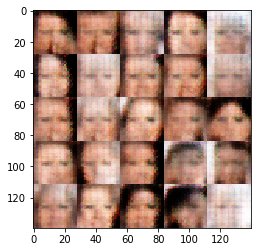

Epoch 0/1... Discriminator Loss: 0.7270... Generator Loss: 1.9242
Epoch 0/1... Discriminator Loss: 0.9997... Generator Loss: 1.0599
Epoch 0/1... Discriminator Loss: 0.6354... Generator Loss: 1.7376
Epoch 0/1... Discriminator Loss: 0.8562... Generator Loss: 1.3700
Epoch 0/1... Discriminator Loss: 0.5437... Generator Loss: 1.2847


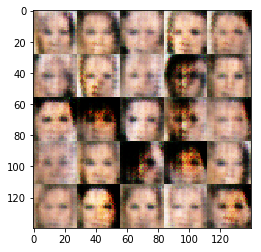

Epoch 0/1... Discriminator Loss: 0.7688... Generator Loss: 1.2064
Epoch 0/1... Discriminator Loss: 0.5148... Generator Loss: 2.4668
Epoch 0/1... Discriminator Loss: 1.3061... Generator Loss: 2.7629
Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 0.8854
Epoch 0/1... Discriminator Loss: 0.8165... Generator Loss: 1.2199


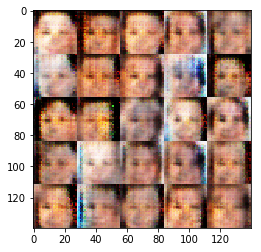

Epoch 0/1... Discriminator Loss: 0.9596... Generator Loss: 0.9064
Epoch 0/1... Discriminator Loss: 0.7304... Generator Loss: 1.6278
Epoch 0/1... Discriminator Loss: 0.8652... Generator Loss: 2.6373
Epoch 0/1... Discriminator Loss: 0.9849... Generator Loss: 0.6505
Epoch 0/1... Discriminator Loss: 1.6563... Generator Loss: 0.4373


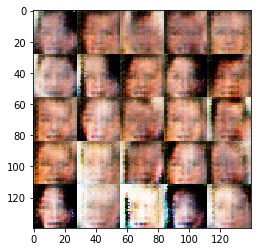

Epoch 0/1... Discriminator Loss: 1.4395... Generator Loss: 0.4544
Epoch 0/1... Discriminator Loss: 0.8776... Generator Loss: 1.0336
Epoch 0/1... Discriminator Loss: 2.9771... Generator Loss: 0.1204
Epoch 0/1... Discriminator Loss: 0.7706... Generator Loss: 1.8222
Epoch 0/1... Discriminator Loss: 0.9710... Generator Loss: 0.7709


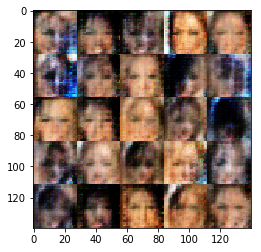

Epoch 0/1... Discriminator Loss: 0.5457... Generator Loss: 2.2274
Epoch 0/1... Discriminator Loss: 1.3352... Generator Loss: 0.6484
Epoch 0/1... Discriminator Loss: 0.8427... Generator Loss: 2.0770
Epoch 0/1... Discriminator Loss: 0.8723... Generator Loss: 2.5745
Epoch 0/1... Discriminator Loss: 1.4185... Generator Loss: 0.4699


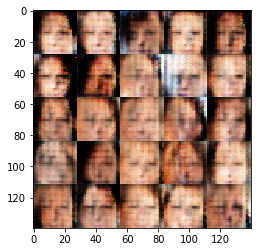

Epoch 0/1... Discriminator Loss: 0.5993... Generator Loss: 1.9166
Epoch 0/1... Discriminator Loss: 0.7344... Generator Loss: 1.2261
Epoch 0/1... Discriminator Loss: 0.7683... Generator Loss: 1.0607
Epoch 0/1... Discriminator Loss: 1.4499... Generator Loss: 0.4545
Epoch 0/1... Discriminator Loss: 0.9997... Generator Loss: 2.2413


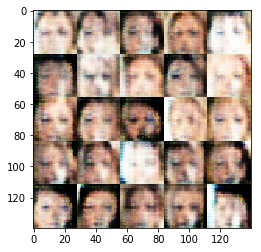

Epoch 0/1... Discriminator Loss: 0.8641... Generator Loss: 1.1067
Epoch 0/1... Discriminator Loss: 1.6879... Generator Loss: 0.3981
Epoch 0/1... Discriminator Loss: 0.8647... Generator Loss: 1.4448
Epoch 0/1... Discriminator Loss: 1.5314... Generator Loss: 2.7574
Epoch 0/1... Discriminator Loss: 0.7329... Generator Loss: 1.4603


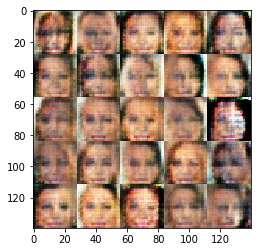

Epoch 0/1... Discriminator Loss: 0.7841... Generator Loss: 1.3571
Epoch 0/1... Discriminator Loss: 1.5664... Generator Loss: 0.4721
Epoch 0/1... Discriminator Loss: 0.7424... Generator Loss: 1.5081
Epoch 0/1... Discriminator Loss: 0.8869... Generator Loss: 2.0612
Epoch 0/1... Discriminator Loss: 0.6854... Generator Loss: 2.3468


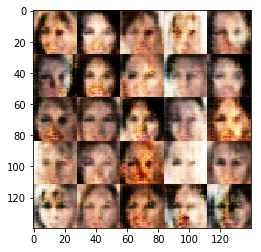

Epoch 0/1... Discriminator Loss: 1.2134... Generator Loss: 0.6714
Epoch 0/1... Discriminator Loss: 0.6571... Generator Loss: 2.0114
Epoch 0/1... Discriminator Loss: 0.7757... Generator Loss: 2.1032
Epoch 0/1... Discriminator Loss: 0.8240... Generator Loss: 2.4007
Epoch 0/1... Discriminator Loss: 1.1897... Generator Loss: 1.8599


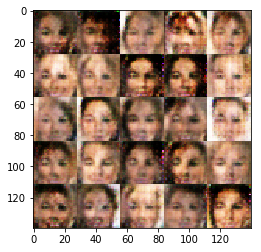

Epoch 0/1... Discriminator Loss: 1.0372... Generator Loss: 2.0502
Epoch 0/1... Discriminator Loss: 0.9050... Generator Loss: 2.2692
Epoch 0/1... Discriminator Loss: 0.8384... Generator Loss: 1.0603
Epoch 0/1... Discriminator Loss: 0.3767... Generator Loss: 2.8138
Epoch 0/1... Discriminator Loss: 0.6898... Generator Loss: 1.6666


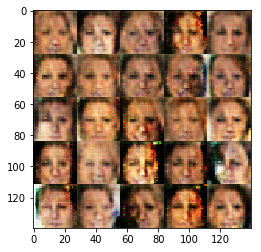

Epoch 0/1... Discriminator Loss: 0.9548... Generator Loss: 1.8161
Epoch 0/1... Discriminator Loss: 1.1649... Generator Loss: 2.0474
Epoch 0/1... Discriminator Loss: 0.9671... Generator Loss: 1.9025
Epoch 0/1... Discriminator Loss: 1.4020... Generator Loss: 1.7643
Epoch 0/1... Discriminator Loss: 1.1028... Generator Loss: 0.6770


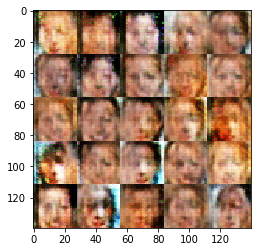

Epoch 0/1... Discriminator Loss: 0.9277... Generator Loss: 0.9365
Epoch 0/1... Discriminator Loss: 0.7774... Generator Loss: 2.2782
Epoch 0/1... Discriminator Loss: 1.1384... Generator Loss: 0.6295
Epoch 0/1... Discriminator Loss: 1.2334... Generator Loss: 1.0811
Epoch 0/1... Discriminator Loss: 0.9348... Generator Loss: 2.1008


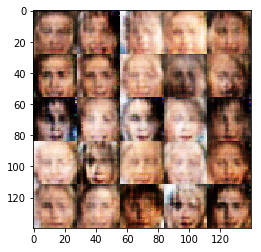

Epoch 0/1... Discriminator Loss: 0.9452... Generator Loss: 1.0924
Epoch 0/1... Discriminator Loss: 0.6012... Generator Loss: 1.6942
Epoch 0/1... Discriminator Loss: 1.0613... Generator Loss: 2.1109
Epoch 0/1... Discriminator Loss: 1.0145... Generator Loss: 1.1245
Epoch 0/1... Discriminator Loss: 0.6965... Generator Loss: 2.0226


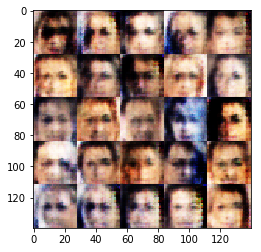

Epoch 0/1... Discriminator Loss: 1.4787... Generator Loss: 0.4437
Epoch 0/1... Discriminator Loss: 0.6502... Generator Loss: 1.8448
Epoch 0/1... Discriminator Loss: 0.7810... Generator Loss: 1.5189
Epoch 0/1... Discriminator Loss: 0.8096... Generator Loss: 1.6428
Epoch 0/1... Discriminator Loss: 0.8427... Generator Loss: 1.3613


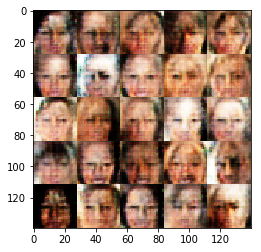

Epoch 0/1... Discriminator Loss: 0.9804... Generator Loss: 1.1539
Epoch 0/1... Discriminator Loss: 1.2674... Generator Loss: 2.8251
Epoch 0/1... Discriminator Loss: 0.9507... Generator Loss: 1.2934
Epoch 0/1... Discriminator Loss: 0.7109... Generator Loss: 1.8342
Epoch 0/1... Discriminator Loss: 0.6678... Generator Loss: 1.4538


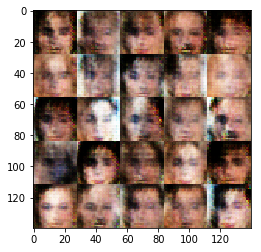

Epoch 0/1... Discriminator Loss: 1.2064... Generator Loss: 0.7164
Epoch 0/1... Discriminator Loss: 0.5627... Generator Loss: 2.0297
Epoch 0/1... Discriminator Loss: 1.2550... Generator Loss: 0.5079
Epoch 0/1... Discriminator Loss: 1.3762... Generator Loss: 0.5595
Epoch 0/1... Discriminator Loss: 1.2927... Generator Loss: 1.0491


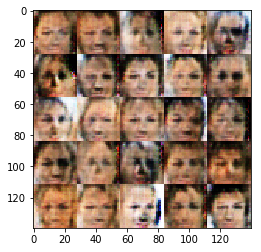

Epoch 0/1... Discriminator Loss: 0.7281... Generator Loss: 1.5377
Epoch 0/1... Discriminator Loss: 0.7113... Generator Loss: 2.2323
Epoch 0/1... Discriminator Loss: 0.7669... Generator Loss: 1.0407
Epoch 0/1... Discriminator Loss: 1.1080... Generator Loss: 2.7218
Epoch 0/1... Discriminator Loss: 0.9324... Generator Loss: 1.6531


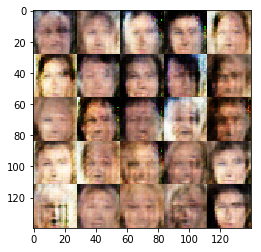

Epoch 0/1... Discriminator Loss: 2.1208... Generator Loss: 0.2173
Epoch 0/1... Discriminator Loss: 0.9016... Generator Loss: 1.7457
Epoch 0/1... Discriminator Loss: 0.8108... Generator Loss: 1.4477
Epoch 0/1... Discriminator Loss: 0.9070... Generator Loss: 1.0934
Epoch 0/1... Discriminator Loss: 1.0116... Generator Loss: 1.1332


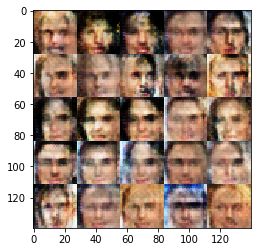

Epoch 0/1... Discriminator Loss: 0.7388... Generator Loss: 1.4060
Epoch 0/1... Discriminator Loss: 0.7910... Generator Loss: 1.0597
Epoch 0/1... Discriminator Loss: 0.8665... Generator Loss: 1.3523
Epoch 0/1... Discriminator Loss: 0.9711... Generator Loss: 0.9251
Epoch 0/1... Discriminator Loss: 0.6788... Generator Loss: 1.4332


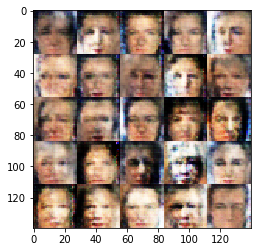

Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 1.1274
Epoch 0/1... Discriminator Loss: 0.8264... Generator Loss: 1.7040
Epoch 0/1... Discriminator Loss: 1.1872... Generator Loss: 0.6897
Epoch 0/1... Discriminator Loss: 0.7219... Generator Loss: 1.3722
Epoch 0/1... Discriminator Loss: 0.9092... Generator Loss: 1.2873


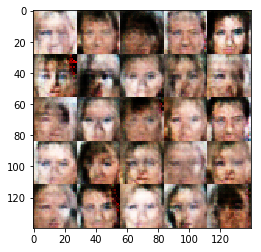

Epoch 0/1... Discriminator Loss: 1.7831... Generator Loss: 0.2731
Epoch 0/1... Discriminator Loss: 1.1898... Generator Loss: 3.7885
Epoch 0/1... Discriminator Loss: 0.6068... Generator Loss: 1.3914
Epoch 0/1... Discriminator Loss: 1.2441... Generator Loss: 0.7013
Epoch 0/1... Discriminator Loss: 0.9015... Generator Loss: 1.8064


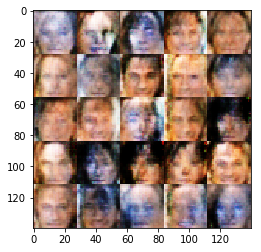

Epoch 0/1... Discriminator Loss: 0.9037... Generator Loss: 0.9182
Epoch 0/1... Discriminator Loss: 0.8036... Generator Loss: 1.3376
Epoch 0/1... Discriminator Loss: 0.7167... Generator Loss: 1.6047
Epoch 0/1... Discriminator Loss: 0.8555... Generator Loss: 1.1699
Epoch 0/1... Discriminator Loss: 1.5534... Generator Loss: 0.5003


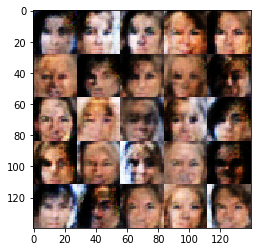

Epoch 0/1... Discriminator Loss: 0.7676... Generator Loss: 1.5124
Epoch 0/1... Discriminator Loss: 0.8503... Generator Loss: 2.0850
Epoch 0/1... Discriminator Loss: 0.8837... Generator Loss: 2.0226
Epoch 0/1... Discriminator Loss: 1.1899... Generator Loss: 0.7972
Epoch 0/1... Discriminator Loss: 2.1186... Generator Loss: 3.7082


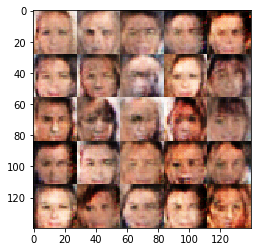

Epoch 0/1... Discriminator Loss: 0.9932... Generator Loss: 0.8265
Epoch 0/1... Discriminator Loss: 0.7189... Generator Loss: 1.6348
Epoch 0/1... Discriminator Loss: 0.8227... Generator Loss: 1.6106
Epoch 0/1... Discriminator Loss: 1.2552... Generator Loss: 3.1236
Epoch 0/1... Discriminator Loss: 0.9544... Generator Loss: 0.7430


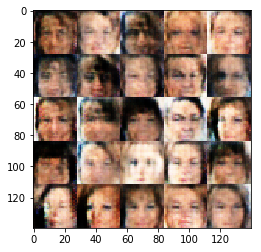

Epoch 0/1... Discriminator Loss: 0.9764... Generator Loss: 2.9409
Epoch 0/1... Discriminator Loss: 0.8858... Generator Loss: 2.8920
Epoch 0/1... Discriminator Loss: 0.9231... Generator Loss: 1.9800
Epoch 0/1... Discriminator Loss: 1.2276... Generator Loss: 3.0620
Epoch 0/1... Discriminator Loss: 1.0021... Generator Loss: 1.0100


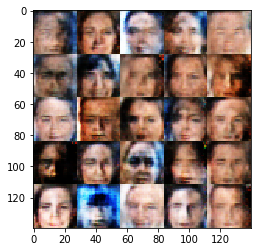

Epoch 0/1... Discriminator Loss: 0.6144... Generator Loss: 1.6096
Epoch 0/1... Discriminator Loss: 1.5173... Generator Loss: 0.4776
Epoch 0/1... Discriminator Loss: 0.8186... Generator Loss: 1.3530
Epoch 0/1... Discriminator Loss: 1.5574... Generator Loss: 0.3721
Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 0.7322


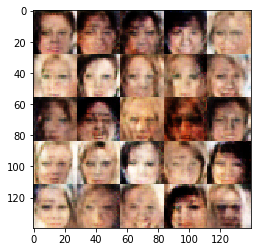

Epoch 0/1... Discriminator Loss: 1.5646... Generator Loss: 3.0338
Epoch 0/1... Discriminator Loss: 1.0647... Generator Loss: 0.7945
Epoch 0/1... Discriminator Loss: 0.9785... Generator Loss: 1.1333
Epoch 0/1... Discriminator Loss: 0.7468... Generator Loss: 1.6621
Epoch 0/1... Discriminator Loss: 1.0419... Generator Loss: 0.8698


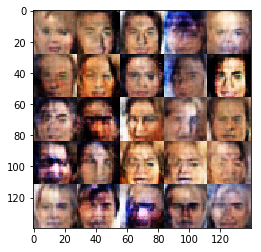

Epoch 0/1... Discriminator Loss: 0.9546... Generator Loss: 1.0728
Epoch 0/1... Discriminator Loss: 0.9275... Generator Loss: 1.8547
Epoch 0/1... Discriminator Loss: 1.0314... Generator Loss: 1.4078
Epoch 0/1... Discriminator Loss: 1.3972... Generator Loss: 0.5314
Epoch 0/1... Discriminator Loss: 1.1663... Generator Loss: 0.9203


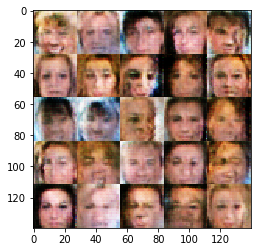

Epoch 0/1... Discriminator Loss: 1.1746... Generator Loss: 1.7912
Epoch 0/1... Discriminator Loss: 1.4038... Generator Loss: 0.4224
Epoch 0/1... Discriminator Loss: 1.0208... Generator Loss: 0.8403
Epoch 0/1... Discriminator Loss: 1.0434... Generator Loss: 1.2463
Epoch 0/1... Discriminator Loss: 1.4125... Generator Loss: 0.5161


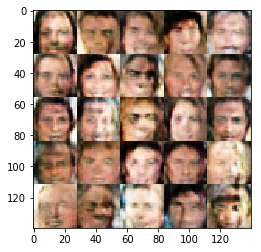

Epoch 0/1... Discriminator Loss: 0.9970... Generator Loss: 1.3702
Epoch 0/1... Discriminator Loss: 0.9086... Generator Loss: 1.0635
Epoch 0/1... Discriminator Loss: 1.3675... Generator Loss: 0.5036
Epoch 0/1... Discriminator Loss: 0.8950... Generator Loss: 1.2946
Epoch 0/1... Discriminator Loss: 1.8473... Generator Loss: 0.3374


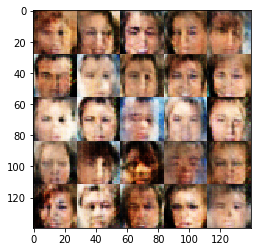

Epoch 0/1... Discriminator Loss: 0.8406... Generator Loss: 1.4537
Epoch 0/1... Discriminator Loss: 0.9189... Generator Loss: 1.5141
Epoch 0/1... Discriminator Loss: 1.0956... Generator Loss: 0.6773
Epoch 0/1... Discriminator Loss: 0.9287... Generator Loss: 2.0329
Epoch 0/1... Discriminator Loss: 1.3223... Generator Loss: 1.7238


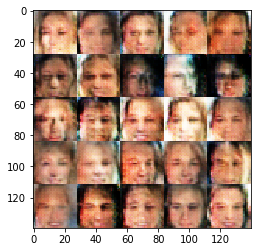

Epoch 0/1... Discriminator Loss: 1.1367... Generator Loss: 2.2324
Epoch 0/1... Discriminator Loss: 1.2510... Generator Loss: 0.7202
Epoch 0/1... Discriminator Loss: 0.8166... Generator Loss: 1.2343
Epoch 0/1... Discriminator Loss: 1.2544... Generator Loss: 0.7642
Epoch 0/1... Discriminator Loss: 0.9442... Generator Loss: 1.1632


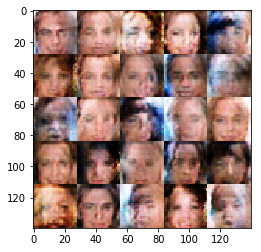

Epoch 0/1... Discriminator Loss: 1.2962... Generator Loss: 0.6313
Epoch 0/1... Discriminator Loss: 1.1092... Generator Loss: 1.7981
Epoch 0/1... Discriminator Loss: 0.9861... Generator Loss: 0.9907
Epoch 0/1... Discriminator Loss: 0.8524... Generator Loss: 0.9778
Epoch 0/1... Discriminator Loss: 1.5197... Generator Loss: 0.4548


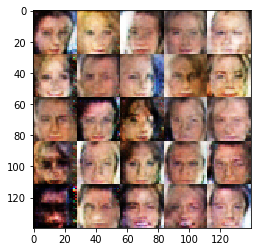

Epoch 0/1... Discriminator Loss: 1.0720... Generator Loss: 1.1453
Epoch 0/1... Discriminator Loss: 1.1031... Generator Loss: 2.3466
Epoch 0/1... Discriminator Loss: 1.0245... Generator Loss: 1.5454
Epoch 0/1... Discriminator Loss: 1.1876... Generator Loss: 0.7456
Epoch 0/1... Discriminator Loss: 1.1566... Generator Loss: 1.7034


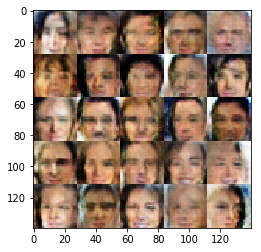

Epoch 0/1... Discriminator Loss: 1.2881... Generator Loss: 0.8889
Epoch 0/1... Discriminator Loss: 0.9429... Generator Loss: 1.6135
Epoch 0/1... Discriminator Loss: 1.0048... Generator Loss: 0.9362
Epoch 0/1... Discriminator Loss: 1.3888... Generator Loss: 0.5421
Epoch 0/1... Discriminator Loss: 1.0437... Generator Loss: 1.2531


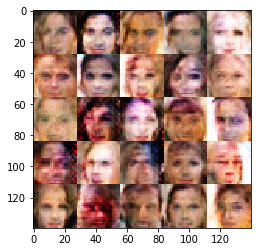

Epoch 0/1... Discriminator Loss: 1.1343... Generator Loss: 0.8874
Epoch 0/1... Discriminator Loss: 0.9013... Generator Loss: 0.8626
Epoch 0/1... Discriminator Loss: 1.4072... Generator Loss: 0.6288
Epoch 0/1... Discriminator Loss: 0.9599... Generator Loss: 1.0955
Epoch 0/1... Discriminator Loss: 1.3488... Generator Loss: 2.8024


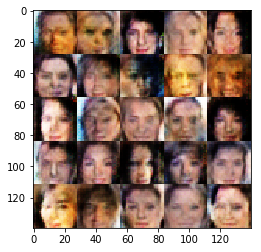

Epoch 0/1... Discriminator Loss: 0.8979... Generator Loss: 1.9059
Epoch 0/1... Discriminator Loss: 1.0174... Generator Loss: 1.0604
Epoch 0/1... Discriminator Loss: 0.9732... Generator Loss: 1.1819
Epoch 0/1... Discriminator Loss: 1.1601... Generator Loss: 1.3992
Epoch 0/1... Discriminator Loss: 1.1700... Generator Loss: 0.7952


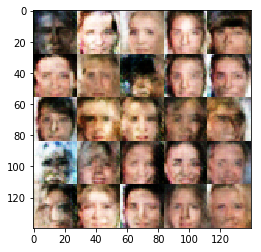

Epoch 0/1... Discriminator Loss: 0.9531... Generator Loss: 1.3104
Epoch 0/1... Discriminator Loss: 0.8245... Generator Loss: 1.2482
Epoch 0/1... Discriminator Loss: 1.1365... Generator Loss: 1.4963
Epoch 0/1... Discriminator Loss: 1.0212... Generator Loss: 1.1306
Epoch 0/1... Discriminator Loss: 0.9398... Generator Loss: 1.5805


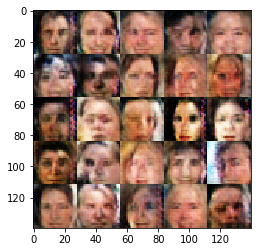

Epoch 0/1... Discriminator Loss: 0.9133... Generator Loss: 1.1674
Epoch 0/1... Discriminator Loss: 1.0681... Generator Loss: 2.5459
Epoch 0/1... Discriminator Loss: 0.8921... Generator Loss: 1.4038
Epoch 0/1... Discriminator Loss: 1.2608... Generator Loss: 1.3326
Epoch 0/1... Discriminator Loss: 1.1623... Generator Loss: 1.7264


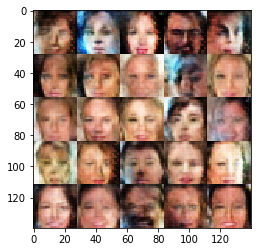

Epoch 0/1... Discriminator Loss: 0.6790... Generator Loss: 1.7842
Epoch 0/1... Discriminator Loss: 1.0655... Generator Loss: 1.9307
Epoch 0/1... Discriminator Loss: 1.0948... Generator Loss: 0.9988
Epoch 0/1... Discriminator Loss: 1.1283... Generator Loss: 0.9249
Epoch 0/1... Discriminator Loss: 1.3555... Generator Loss: 2.1479


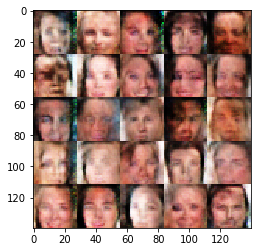

Epoch 0/1... Discriminator Loss: 1.1415... Generator Loss: 0.9507
Epoch 0/1... Discriminator Loss: 1.2408... Generator Loss: 0.8425
Epoch 0/1... Discriminator Loss: 1.0019... Generator Loss: 1.0213
Epoch 0/1... Discriminator Loss: 0.9038... Generator Loss: 1.1854
Epoch 0/1... Discriminator Loss: 0.7971... Generator Loss: 1.6336


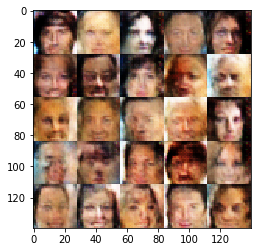

Epoch 0/1... Discriminator Loss: 1.3811... Generator Loss: 2.4113
Epoch 0/1... Discriminator Loss: 0.9818... Generator Loss: 1.5598
Epoch 0/1... Discriminator Loss: 1.0453... Generator Loss: 1.2256
Epoch 0/1... Discriminator Loss: 2.0391... Generator Loss: 0.2869
Epoch 0/1... Discriminator Loss: 1.1211... Generator Loss: 0.7312


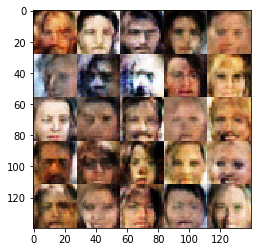

Epoch 0/1... Discriminator Loss: 0.8300... Generator Loss: 1.0847
Epoch 0/1... Discriminator Loss: 1.0648... Generator Loss: 1.3030
Epoch 0/1... Discriminator Loss: 1.0673... Generator Loss: 0.8925
Epoch 0/1... Discriminator Loss: 1.1673... Generator Loss: 0.8295
Epoch 0/1... Discriminator Loss: 1.3109... Generator Loss: 2.4594


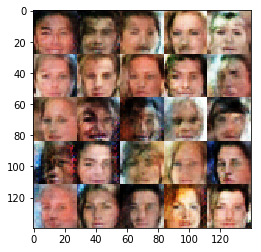

Epoch 0/1... Discriminator Loss: 0.8593... Generator Loss: 1.2739
Epoch 0/1... Discriminator Loss: 1.1532... Generator Loss: 0.8861
Epoch 0/1... Discriminator Loss: 1.1271... Generator Loss: 1.2459
Epoch 0/1... Discriminator Loss: 1.0950... Generator Loss: 1.1305
Epoch 0/1... Discriminator Loss: 1.2483... Generator Loss: 1.1511


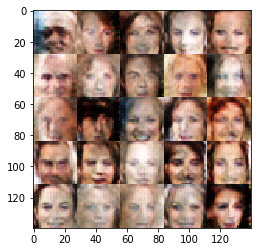

Epoch 0/1... Discriminator Loss: 0.6693... Generator Loss: 1.2616
Epoch 0/1... Discriminator Loss: 1.1208... Generator Loss: 2.0423
Epoch 0/1... Discriminator Loss: 1.2406... Generator Loss: 0.7664
Epoch 0/1... Discriminator Loss: 2.1266... Generator Loss: 0.2441
Epoch 0/1... Discriminator Loss: 1.0322... Generator Loss: 1.2893


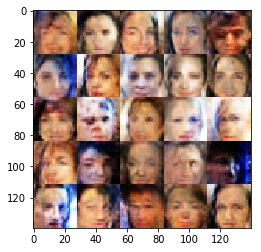

Epoch 0/1... Discriminator Loss: 1.1692... Generator Loss: 0.8757
Epoch 0/1... Discriminator Loss: 1.2994... Generator Loss: 2.2364
Epoch 0/1... Discriminator Loss: 0.9455... Generator Loss: 0.9450
Epoch 0/1... Discriminator Loss: 1.1094... Generator Loss: 0.8855
Epoch 0/1... Discriminator Loss: 1.7876... Generator Loss: 0.3346


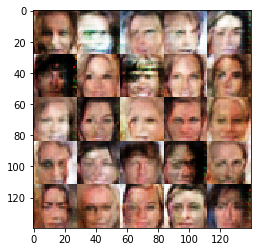

Epoch 0/1... Discriminator Loss: 1.4301... Generator Loss: 0.4225
Epoch 0/1... Discriminator Loss: 0.9424... Generator Loss: 1.4915
Epoch 0/1... Discriminator Loss: 1.0710... Generator Loss: 0.9314
Epoch 0/1... Discriminator Loss: 1.1459... Generator Loss: 1.3687
Epoch 0/1... Discriminator Loss: 0.9604... Generator Loss: 1.0680


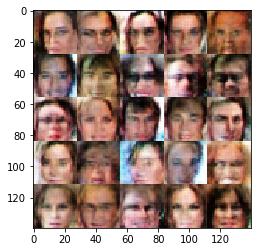

Epoch 0/1... Discriminator Loss: 0.8812... Generator Loss: 1.2282
Epoch 0/1... Discriminator Loss: 1.0816... Generator Loss: 1.0810
Epoch 0/1... Discriminator Loss: 1.6326... Generator Loss: 0.3661
Epoch 0/1... Discriminator Loss: 1.0611... Generator Loss: 1.0740
Epoch 0/1... Discriminator Loss: 0.8771... Generator Loss: 1.5442


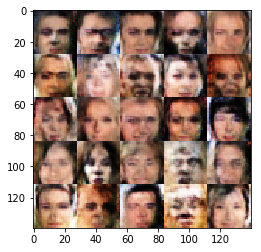

Epoch 0/1... Discriminator Loss: 1.2884... Generator Loss: 0.8585
Epoch 0/1... Discriminator Loss: 1.1948... Generator Loss: 0.7848
Epoch 0/1... Discriminator Loss: 0.8896... Generator Loss: 1.4974
Epoch 0/1... Discriminator Loss: 1.1016... Generator Loss: 0.9400
Epoch 0/1... Discriminator Loss: 1.0718... Generator Loss: 0.9579


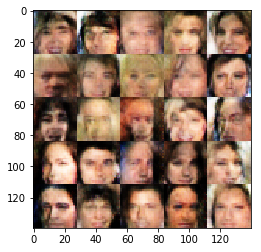

Epoch 0/1... Discriminator Loss: 0.9796... Generator Loss: 0.8057
Epoch 0/1... Discriminator Loss: 0.9079... Generator Loss: 1.1100
Epoch 0/1... Discriminator Loss: 0.8169... Generator Loss: 1.6925
Epoch 0/1... Discriminator Loss: 1.0168... Generator Loss: 0.8867
Epoch 0/1... Discriminator Loss: 1.5068... Generator Loss: 0.4398


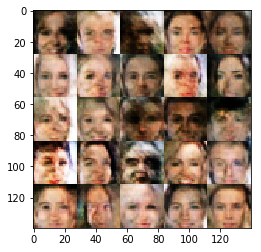

Epoch 0/1... Discriminator Loss: 1.5707... Generator Loss: 0.4171
Epoch 0/1... Discriminator Loss: 1.0112... Generator Loss: 1.3037
Epoch 0/1... Discriminator Loss: 1.0903... Generator Loss: 1.0407
Epoch 0/1... Discriminator Loss: 1.0756... Generator Loss: 0.8946
Epoch 0/1... Discriminator Loss: 1.1240... Generator Loss: 1.6330


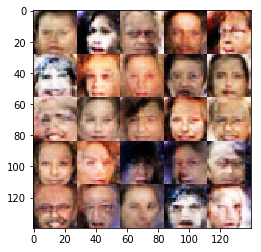

Epoch 0/1... Discriminator Loss: 1.1700... Generator Loss: 0.7039
Epoch 0/1... Discriminator Loss: 1.3635... Generator Loss: 0.8197
Epoch 0/1... Discriminator Loss: 1.0928... Generator Loss: 0.8216
Epoch 0/1... Discriminator Loss: 0.9141... Generator Loss: 0.9237
Epoch 0/1... Discriminator Loss: 0.9531... Generator Loss: 1.3543


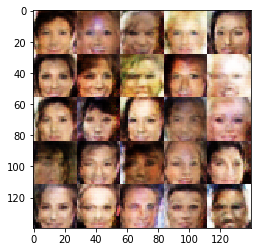

Epoch 0/1... Discriminator Loss: 1.2362... Generator Loss: 2.1437
Epoch 0/1... Discriminator Loss: 1.2628... Generator Loss: 0.6971
Epoch 0/1... Discriminator Loss: 1.1350... Generator Loss: 0.8756
Epoch 0/1... Discriminator Loss: 1.4774... Generator Loss: 0.4352
Epoch 0/1... Discriminator Loss: 1.0273... Generator Loss: 1.4446


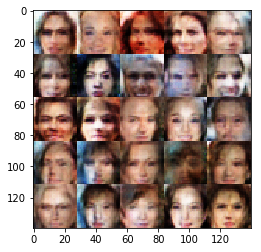

Epoch 0/1... Discriminator Loss: 1.0579... Generator Loss: 0.9815
Epoch 0/1... Discriminator Loss: 1.7118... Generator Loss: 0.3645


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.